# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)

## Forward Simulations in SPECFEM2D and 3D

This notebook is meant to walk Users through an introduction to `SPECFEM2D`, from a) navigating a SPECFEM2D working directory, to b) generating a mesh, to c) running forward simulations. We make note of important files and steps to take when running forward simulations in SPECFEM. Background material is included to understand the task at hand, and we also draw parallels with `SPECFEM3D`, illustrating how to mesh and run simulations on a simple 3D domain. At the end of the workshop, we will take a look at how we can use `SeisFlows` to automate SPECFEM2D for running forward simulations.

-----------

### 0) Relevant Information

>__NOTE:__ These instructions should be run from inside the Docker container, using Jupyter Lab. The Docker container should have the adjTomo toolkit installed (SeisFlows, Pyatoa, PySEP), as well as SPECFEM2D and SPECEFM3D compiled with MPI. 

**Relevant Links:** 
- !!! ADD DAY 1 SLIDES HERE !!!
- Workshop Material: https://github.com/adjtomo/adjdocs/tree/main/workshops/2022-10-05_specfem_users
- Today's Notebook: !!! ADD THIS !!!

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the `Run` button at the top, or by hitting `Shift + Enter`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. Where the number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands


## 1) Background !!! TODO !!!


Potential topics: 
- Seismic waveforms
- Numerical modeling
- Spectral element method
- Meshes


## 2) SPECFEM2D Tour

>__NOTE__: The `devel` branch of all SPECFEM versions contains the most up to date codebase

- GitHub Repository: https://github.com/geodynamics/specfem2d/tree/devel
- SPECFEM2D Manual: https://specfem2d.readthedocs.io/en/latest/

In [ ]:
%cd /home/scoped/specfem2d

### a) Binary Executables in *bin/* directory

In this workshop container, we have already downloaded (git clone), configured (choosing compilers and compiler options) and compiled (make all) SPECFEM2D. The binary executable files are located in the `bin/` directory. Each of these executables performs a different function in the package.

In [ ]:
# Let's have a look at the executables
! ls bin

The two most important executables we will be using today are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D` is used to generate our numerical mesh, the skeleton of the domain upon which we run our numerical simulations. 
- `xspecfem2D` runs the spectral element solver, generating synthetic seismograms for a given source and set of stations.

Some other important executables we will use:
- `xsmooth_sem` smooths models, gradients and kernels by convolving them with a 2D Gaussian. Users can define the horizontal and vertical half-widths of the Gaussian.

### b) Metadata in *DATA/* directory

Data that the User will provide to SPECFEM should be stored in the *DATA/* directory. The most important files that we will concern ourselves with are the `Par_file`, `SOURCE` and `STATIONS` files.

-`Par_file`: The parameter file which allows the User to adjust parameters for a given simulation  
-`SOURCE`: Defines source characteristics (e.g., moment tensor, force). **NOTE**: SPECFEM2D and SPECFEM3D have a number of different types of available source files (e.g., SOURCE, FORCESOLUTION, CMTSOLUTION)  
-`STATIONS`: Defines station codes and locations (either Cartesian or geographic). **NOTE**: Station information may also be defined in the `Par_file`

The following commands open these files for the SPECFEM2D example problem

In [ ]:
! ls DATA

In [ ]:
! head -38 DATA/Par_file

In [ ]:
! cat DATA/SOURCE

In [ ]:
# In this example, the Par_file defines station information directly
! head -194 DATA/Par_file | tail -n 16

In [ ]:
# Other examples will define station information using STATIONS files
! head -5 EXAMPLES/Tape2007/DATA/STATIONS_checker

### c) Results stored in *OUTPUT_FILES/* directory

Any outputs generated by SPECFEM will be stored in the `OUTPUT_FILES/` directory. These include log and error messages, synthetic seismograms, figures, and output files of one executable that may be required by another.

>__NOTE__: SPECFEM also maintains a DATABASE directory (typically called `DATABASES_MPI/`) which is used to store large database files containing the entire GLL mesh and model, as well as intermediate files such as the saved forward wavefield. This directory may be the same as `OUTPUT_FILES/`, or may be it's own separate directory.

In [ ]:
# Currently empty because we have not run any executables
! ls OUTPUT_FILES

## 3) Running the mesher `xmeshfem2D` 

The first thing we need to do when approaching numerical simulations is to generate our numerical mesh. There are multiple approaches to meshing, such as using external software such as Trellis. During this workshop we will use SPECFEM's internal meshing software, known as `Meshfem`.

### a) Velocity Model Parameters

In SPECFEM2D, mesh parameters are defined in the `Par_file`. There are various parameter options we can use to customize our mesher run. The following parameter set allows us to read input values from the `Par_file`

`NPROC`: defines the number of processors used to partition the mesh  
`MODEL`=default:  

>__NOTE:__ In SPECFEM3D, Meshfem files are defined separately to provide more control over a 3D domain. These files are typically stored in `specfem3d/DATA/meshfem3D_files`. We will look at these later in the notebook.

In [ ]:
! head -273 DATA/Par_file | tail -n 34

In the output above we can see that our `Par_file` defines 4 separate material parameters, each with varying values for density and velocity. 

### b) Internal Mesher Parameters

The internal mesher also has another set of parameters that allows Users to provide interfaces, geometry, absorbing boundary conditions. These parameters are also used to distribute the material properties defined above, to specific regions of the mesh


In [ ]:
! head -320 DATA/Par_file | tail -n 29

### c) Setting Parameters

We will set a few `Par_file` parameters to tell SPECFEM to output a few additional files that will facilitate understanding the outputs of `xmeshfem2D`.

>__NOTE:__ We will use the `seisflows sempar` commmand to print and edit values from the SPECFEM2D `Par_file`. This is simply a convenience function but can be replaced by bash commands like 'cat' + 'awk', or by opening the `Par_file` with a text editor.

In [44]:
# seisflows sempar -P ${Par_file} {key} {value:optional}
! seisflows sempar -P DATA/Par_file model
! seisflows sempar -P DATA/Par_file setup_with_binary_databases 1
! seisflows sempar -P DATA/Par_file save_model binary

MODEL: default

	parameter file 'Data/Par_file' does not exist

SAVE_MODEL: default -> binary
save_ASCII_kernels: .true. -> .false.


-------------
Explanations of the changes we are made include:

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (default option)  
`setup_with_binary_databases`: Writes database files in binary format   
`SAVE_MODEL`: Write model files in binary format  

### d) Run Meshfem Executable

Becuse this example problem is already set up for us, we can simply run the executable. `xmeshfem2D` will look for relevant data in the *DATA/* directory, and generate our numerical mesh, and model, in the *OUTPUT_FILES/* directory. 

>__NOTE__: WE will use MPI to run the executable, but set `-n=1` to specify that this is a serial task. We also redirect the output to a log file so that we can take a look at different parts of it.

In [54]:
# The Par_file NPROC parameter must match the `-n` flag for MPI
! seisflows sempar -P DATA/Par_file nproc

NPROC: 1


In [45]:
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

In [46]:
! ls OUTPUT_FILES

Database00000.bin   mesh_partition_number.vtk
mesh_materials.vtk  output_meshfem2d.txt


In [47]:
# We can see that `xmeshfem2D` has created a STATIONS file for us
! ls DATA/

Par_file  SOURCE  STATIONS


In [48]:
! cat DATA/STATIONS

S0001    AA          300.0000000         2997.7298909       0.0         0.0
S0002    AA          640.0000000         3008.0430011       0.0         0.0
S0003    AA          980.0000000         3090.8224062       0.0         0.0
S0004    AA         1320.0000000         3283.0303923       0.0         0.0
S0005    AA         1660.0000000         3347.8768862       0.0         0.0
S0006    AA         2000.0000000         3250.0000000       0.0         0.0
S0007    AA         2340.0000000         3197.3138031       0.0         0.0
S0008    AA         2680.0000000         3150.9619873       0.0         0.0
S0009    AA         3020.0000000         3086.5939051       0.0         0.0
S0010    AA         3360.0000000         3042.8523748       0.0         0.0
S0011    AA         3700.0000000         3020.6886768       0.0         0.0
S0012    AA         2500.0000000         2500.0000000       0.0         0.0
S0013    AA         2500.0000000         2250.0000000       0.0         0.0
S0014    AA 

!!! Look at the output log file here !!!!

### 4) Running the solver `xspecfem2D`

The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a forward simulation using the provided `SOURCE` and `STATIONS` files. The following set of parameters controls how the output synthetic seismograms are generated

In [51]:
! head -168 DATA/Par_file | tail -n 32

#-----------------------------------------------------------
#
# Receivers
#
#-----------------------------------------------------------

# receiver set parameters for recording stations (i.e. recording points)
# seismotype : record 1=displ 2=veloc 3=accel 4=pressure 5=curl of displ 6=the fluid potential
seismotype                      = 1              # several values can be chosen. For example : 1,2,4

# interval in time steps for writing of seismograms
# every how many time steps we save the seismograms
# (costly, do not use a very small value; if you use a very large value that is larger than the total number
#  of time steps of the run, the seismograms will automatically be saved once at the end of the run anyway)
NTSTEP_BETWEEN_OUTPUT_SEISMOS   = 10000

# set to n to reduce the sampling rate of output seismograms by a factor of n
# defaults to 1, which means no down-sampling
NTSTEP_BETWEEN_OUTPUT_SAMPLE    = 1

# so far, this option can only be used if all the receivers are in a

Some of the more important parameters explained are:

`seismotype`: Sets the units of the output seismograms. This example outputs in units of 'displacement'  
`USER_T0`: Defines when the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source, and is useful e.g., in cases where you have very short source-receiver distances  
`save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files. Useful for quick plotting

In [56]:
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

In [57]:
! ls OUTPUT_FILES

AA.S0001.BXX.semd	    forward_image000000200.jpg
AA.S0001.BXZ.semd	    forward_image000000300.jpg
AA.S0002.BXX.semd	    forward_image000000400.jpg
AA.S0002.BXZ.semd	    forward_image000000500.jpg
AA.S0003.BXX.semd	    forward_image000000600.jpg
AA.S0003.BXZ.semd	    forward_image000000700.jpg
AA.S0004.BXX.semd	    forward_image000000800.jpg
AA.S0004.BXZ.semd	    forward_image000000900.jpg
AA.S0005.BXX.semd	    forward_image000001000.jpg
AA.S0005.BXZ.semd	    forward_image000001100.jpg
AA.S0006.BXX.semd	    forward_image000001200.jpg
AA.S0006.BXZ.semd	    forward_image000001300.jpg
AA.S0007.BXX.semd	    forward_image000001400.jpg
AA.S0007.BXZ.semd	    forward_image000001500.jpg
AA.S0008.BXX.semd	    forward_image000001600.jpg
AA.S0008.BXZ.semd	    mesh_materials.vtk
AA.S0009.BXX.semd	    mesh_partitioning.ps
AA.S0009.BXZ.semd	    mesh_partition_number.vtk
AA.S0010.BXX.semd	    mesh_stability.ps
AA.S0010.BXZ.semd	    mesh_S_wave_dispersion.ps
AA.S0011.BXX.semd	    output_list_stations.tx

!!! Go through the solver log here !!!

### 5) Understanding SPECFEM2D Output Files

The `xspecfem2D` file has created a plethora of results! Let's have a look one by one to see what each of these files are, and how they can help us understand our simulation.

#### a) Velocity Model

`xspecfem2D` outputs the velocity model into the *DATA/* directory. We can use some utility functions written into `SeisFlows` to plot this model to help us visualize our domain.

In [60]:
# The .bin files define our velocity model
! ls DATA/*bin

DATA/proc000000_jacobian.bin	 DATA/proc000000_vp.bin  DATA/proc000000_z.bin
DATA/proc000000_NSPEC_ibool.bin  DATA/proc000000_vs.bin
DATA/proc000000_rho.bin		 DATA/proc000000_x.bin


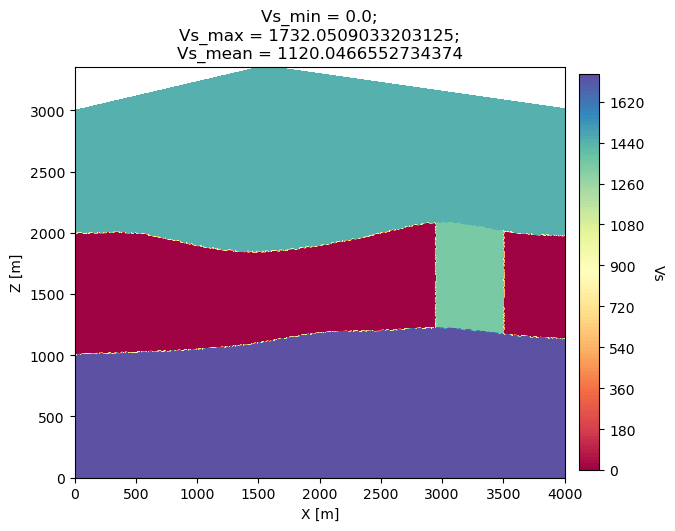

In [63]:
# We can use SeisFlows to plot this model
from seisflows.tools.specfem import Model

m = Model(path="DATA")
m.plot2d(parameter="vs")